# 🎟️ Proyecto de Análisis de Marketing y Comportamiento de Usuarios en Showz
📊 Resumen del proyecto
Este análisis de datos se centra en el comportamiento de los usuarios y el rendimiento del marketing de Showz, una plataforma de venta de entradas para eventos. El objetivo es ofrecer recomendaciones prácticas para optimizar el presupuesto de marketing y mejorar las estrategias de adquisición de clientes.

🧩 El proyecto incluye:

🧠 Análisis del comportamiento del usuario:
Frecuencia de uso, duración de sesiones y patrones de regreso al sitio.

💸 Análisis de ventas e ingresos:
Tiempos de conversión, tamaño promedio de compra y valor de vida del cliente (LTV).

📈 Evaluación del rendimiento de marketing:
Cálculo de costos totales, CAC (costo de adquisición) por canal y ROMI.

🧪 Análisis de cohortes:
Comparación del rendimiento por fuente de tráfico y tipo de dispositivo.

📊 Visualizaciones:
Gráficos que muestran tendencias de visitas, compras y efectividad de campañas.

🧾 Herramientas utilizadas:
Python, pandas, matplotlib, seaborn, Jupyter Notebook

📍Objetivo:
Brindar recomendaciones estratégicas basadas en datos sobre dónde invertir, cuánto y por qué, para maximizar los resultados del marketing.

## Paso 1: Carga y procesamiento de datos.



In [221]:
#Primero cargamos las librerías necesarias para el proyecto.
import pandas as pd #Pandas para la manipulación de datos
import numpy as np 
import scipy.stats as st #Numpy y Scipy para operaciones matemáticas y estadísticas.
import matplotlib.pyplot as plt
import seaborn as sns #Matplotlib y seaborn para visualizaciones.
import math

In [222]:
#Vamos a cargar los datos a continuación.
visits_df = pd.read_csv('../Data/visits_log_us.csv')
orders_df = pd.read_csv('../Data/orders_log_us.csv')
costs_df = pd.read_csv('../Data/costs_us.csv')

### Visits_df

In [223]:
#Ahora vamos a mostrar información general de los 3 datasets.
visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


El DataFrame visits_df contiene información sobre visitas a la página web, incluyendo el dispositivo mediante el cual se inicio la sesión, la fecha y hora de inicio y final de la sesión, la fuente de la cuál provino ese cliente y el identificador único del usuario. Se puede ver que no hay valores ausentes, lo cual es un buen indicativo, voy a convertir las columnas de fechas al tipo de datos correspondientes, las demás son correctas, de igual manera vamos a estandarizar los nombres de las columnas a snake_case.

In [224]:
#Primero estandarizamos los nombres de las columnas.
visits_df.columns = visits_df.columns.str.lower().str.replace(' ', '_')
visits_df.columns


Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [225]:
#Convertimos las columnas start_ts y end_ts a tipo datetime.
visits_df['start_ts'] = pd.to_datetime(visits_df['start_ts'])
visits_df['end_ts'] = pd.to_datetime(visits_df['end_ts'])
visits_df.dtypes

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

In [226]:
#Vamos a buscar valores duplicados.
visits_df.duplicated().sum()

0

Ahora es tiempo de optimizar los datos, para análisis posteriores. Por el momento vamos a agregar las columnas para mes y día de la semana y otra columna para la duración de la sesión.

In [227]:
#Extraemos la fecha de la sesión
visits_df['session_date'] = visits_df['start_ts'].dt.date.astype('datetime64[ns]')
visits_df['session_year'] = visits_df['session_date'].dt.year
visits_df['session_month'] = visits_df['session_date'].dt.month
#Extraemos el número de la semana.
visits_df['session_week'] = visits_df['session_date'].dt.isocalendar().week

#Extraemos el día de la semana.
visits_df['session_dow'] = visits_df['session_date'].dt.day_of_week

#Calculamos la duración de la sesión en segundos.
visits_df['session_duration'] = visits_df['end_ts'] - visits_df['start_ts']
visits_df['session_duration'] = visits_df['session_duration'].dt.total_seconds()
visits_df.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_dow,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51,2,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8,0,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26,5,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20,6,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52,2,0.0


### Orders_df

In [228]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


El DataFrame orders_df contiene información de compras, incluyendo la fecha y hora de compra, el ingreso, y el user ID, los registros están completos. Vamos a estandarizar los nombres de las columnas y a convertir la columna buy_ts a tipo Datetime.

In [229]:
#Estandarizamos el nombre de las columnas.
orders_df.columns = orders_df.columns.str.lower().str.replace(' ', '_')
orders_df.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [230]:
#Convertimos a tipo Datetime
orders_df['buy_ts'] = pd.to_datetime(orders_df['buy_ts'])
orders_df.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

In [231]:
#Vamos a buscar duplicados.
orders_df.duplicated().sum()

0

Para este dataframe vamos a realizar lo mismo que con el otro excepto por la duración de la sesión, para posteriormente poder analizar y calcular las distintas métricas.

In [232]:
orders_df['order_date'] = orders_df['buy_ts'].dt.date.astype('datetime64[ns]')
orders_df['order_year'] = orders_df['buy_ts'].dt.year
orders_df['order_month'] = orders_df['order_date'].dt.month
orders_df['order_dow'] = orders_df['order_date'].dt.day_of_week
orders_df.head()

,buy_ts,revenue,uid,order_date,order_year,order_month,order_dow
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017,6,3
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017,6,3
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017,6,3
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017,6,3
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017,6,3


### Costs_df

In [233]:
costs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


El DataFrame costs_df contiene información sobre los gastos de Marketing, incluyendo la fuente en la que se invirtió(redes sociales, email, etc.), la fecha, y el total gastado en dicha fecha. Primero vamos a estandarizar el nombre de las columnas, después vamos a convertir a tipo datetime la columna dt, después vamos a verificar duplicados.

In [234]:
#Convertimos la columna a tipo Datetime
costs_df['dt'] = pd.to_datetime(costs_df['dt'])
costs_df.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

In [235]:
#Buscamos duplicados.
costs_df.duplicated().sum()

0

---

## Paso 2: Informes y métricas.

Para comenzar con nuestro análisis, calcularemos distintas métricas para dar respuesta a las siguientes preguntas con respecto a las visitas a la tienda de Showz:

* ¿Cuántas personas lo usan cada día, semana y mes?
* ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).
* ¿Cuál es la duración de cada sesión?
* ¿Con qué frecuencia los usuarios regresan?





### Visitas

#### DAU (Daily active users)

In [236]:
#Primero vamos a calcular el número de usuarios que visitan la página al diariamente, esto es el DAU.
visits_dau = visits_df.groupby('session_date')['uid'].nunique().mean()
visits_dau


907.9917582417582

El número promedio de usuarios que visitan la tienda diariamente es de 907.99

---

#### WAU (Weekly active users)

In [237]:
#Ahora calculamos el número de usuarios activos a la semana, es decir el WAU.
visits_wau = visits_df.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
visits_wau

uid    5716.245283
dtype: float64

El número promedio de usuarios que visitan la tienda semanalmente es de 5716.

---

#### MAU (Monthly active users)

In [238]:
#Calculamos el número de usuarios activos mensualmente (MAU).
visits_mau = visits_df.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
visits_mau

uid    23228.416667
dtype: float64

El número promedio de usuarios que visitan la tienda mensualmente es de 23228.

---

#### Comparación 2017 vs 2028.
Las métricas que calculamos anteriormente no nos dicen mucho por si solas, necesitamos compararlas con algo para saber si bien, los usuarios aumentaron o incluso disminuyeron, por lo que voy a calcular unicamente el DAU pero segmentando los datos por año, para darnos una pequeña idea de la situación de la tienda.

In [239]:
#Filtramos los datos para el 2017
visits_2017 = visits_df.query('session_year == 2017')

#Filtramos los datos para el 2018
visits_2018 = visits_df.query('session_year == 2018')

#Calculamos el DAU para el 2017
dau_2017 = visits_2017.groupby('session_date')['uid'].nunique().mean()

#Calculamos el DAU para el 2018
dau_2018 = visits_2018.groupby('session_date')['uid'].nunique().mean()

print(f'''
    El número número promedio de usuarios activos diariamente en 2017 fue de: {dau_2017}, 
    mientras que en 2018 fue de: {dau_2018}
''')



    El número número promedio de usuarios activos diariamente en 2017 fue de: 845.2803738317757, 
    mientras que en 2018 fue de: 997.46



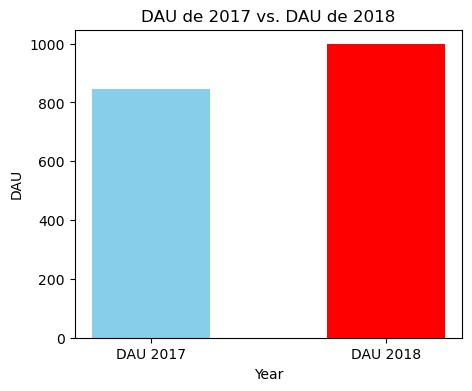

In [240]:
#Vamos a visualizar esta comparación.
labels = ['DAU 2017', 'DAU 2018']
dau_data = [dau_2017, dau_2018]

#Creamos el gráfico.
plt.figure(figsize=(5, 4))
plt.bar(labels, dau_data, color=['skyblue', 'red'], width=0.5)

#Le damos formato.
plt.title('DAU de 2017 vs. DAU de 2018')
plt.xlabel('Year')
plt.ylabel('DAU')

plt.show()



Como vemos en la parte posterior, el número de usuarios para el 2018 ha aumentado en comparación con el 2017, esta comparación puede resultar un poco ambigua, sin embargo nos da una idea de que la compañía de Showz ha crecido en cuanto al número de usuarios que visitan la tienda, además el objetivo de nuestro análisis no es comparar periodos.

---

#### Sesiones por día.

In [241]:
#Calculamos el número de sesiones diarias. 
sessions_per_day = visits_df.groupby('session_date')['uid'].count().mean()
sessions_per_day

987.3626373626373

El número de sesiones diarias supera por muy poco al número de usuarios activos diarios, esto quiere decir que muy pocos usuarios tienden a visitar la página más de una vez al día, lo cual tiene sentido, ya que no van a comprar muchos boletos a distintas horas del día.

---

#### ASL (Average session lenght)

In [242]:
# Ahora vamos a calcular la duración promedio de cada sesión, anteriormente agregamos la columna de duración, por lo que ahora 
# solo tenemos que calcular la media de tal columna.
visits_asl = visits_df['session_duration'].mean()
print('ASL en segundos:', visits_asl)

ASL en segundos: 643.0256872565387


La duración promedio de cada sesión es de 643 segundos, lo cual es bastante, son más de 10 minutos, sin embargo debido a la naturaleza de el producto/servicio que estamos analizando, no podemos concluir que el ASL es bueno, es probable que los usuarios se demoren al elegir sus entradas en los espectáculos.

---

#### Sticky Factor 

In [243]:
sticky_factor_mau = (visits_dau / visits_mau)*100
sticky_factor_mau

uid    3.90897
dtype: float64

In [244]:
sticky_factor_wau = (visits_dau / visits_wau)*100
sticky_factor_wau

uid    15.884409
dtype: float64

Nuestro "Sticky Factor" es bastante bajo, solo el 3.9% de los usuarios activos mensuales usan la plataforma todos los días, mientras que el 15.88% de los usuarios activos semanales están activos cada día. Nuevamente, reitero, debido a la naturaleza de el producto, este Sticky factor no es preocupante, ¿Por qué? porqué las personas no compran entradas para conciertos todos los días, por ende, no entran a la tienda tan a menudo como nos gustaría.

------

### Ventas

Para el DataFrame de orders, con respecto a las ventas que se realizaron en la tienda, vamos a dar respuesta a las siguientes preguntas: 

1. ¿Cuándo empieza la gente a comprar? 
2. ¿Cuántos pedidos hacen durante un período de tiempo dado?
3. ¿Cuál es el tamaño promedio de compra?
4. ¿Cuánto dinero traen? (LTV)

#### TTC (Time to conversion)

In [245]:
#Para calcular el tiempo que transcurre entre el registro y la primera compra de los clientes, primero vamos a encontrar su primera visita.
first_visits = visits_df.groupby('uid')['session_date'].min().reset_index()
first_visits.columns = ['uid', 'first_visit']
first_visits['cohort_month'] = first_visits['first_visit'].dt.to_period('M')

#Ahora debemos encontrar la primera compra de cada usuario.
first_orders = orders_df.groupby('uid')['order_date'].min().reset_index()
first_orders.columns = ['uid', 'first_order']
first_orders['order_month'] = first_orders['first_order'].dt.to_period('M')

#Unimos ambos DataFrames.
cohort_df  = first_visits.merge(first_orders, on='uid', how='inner')

from operator import attrgetter
cohort_df['cohort_index'] = (cohort_df['order_month'] - cohort_df['cohort_month']).apply(attrgetter('n'))

#Ahora creamos la matriz.
cohort_matrix = cohort_df.pivot_table(
    index='cohort_month',
    columns='cohort_index',
    values='uid',
    aggfunc='count'
)
cohort_matrix

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-06,2023.0,170.0,67.0,107.0,119.0,92.0,78.0,59.0,64.0,64.0,26.0,54.0
2017-07,1753.0,95.0,99.0,100.0,89.0,77.0,67.0,62.0,50.0,33.0,33.0,NaN
2017-08,1208.0,118.0,92.0,73.0,65.0,38.0,39.0,38.0,25.0,25.0,NaN,NaN
2017-09,2257.0,268.0,143.0,102.0,59.0,76.0,71.0,40.0,42.0,NaN,NaN,NaN
2017-10,3761.0,327.0,178.0,114.0,97.0,92.0,49.0,60.0,NaN,NaN,NaN,NaN
2017-11,3357.0,392.0,155.0,102.0,127.0,64.0,65.0,NaN,NaN,NaN,NaN,NaN
2017-12,3491.0,237.0,115.0,112.0,45.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,2644.0,244.0,114.0,50.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,2852.0,202.0,62.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


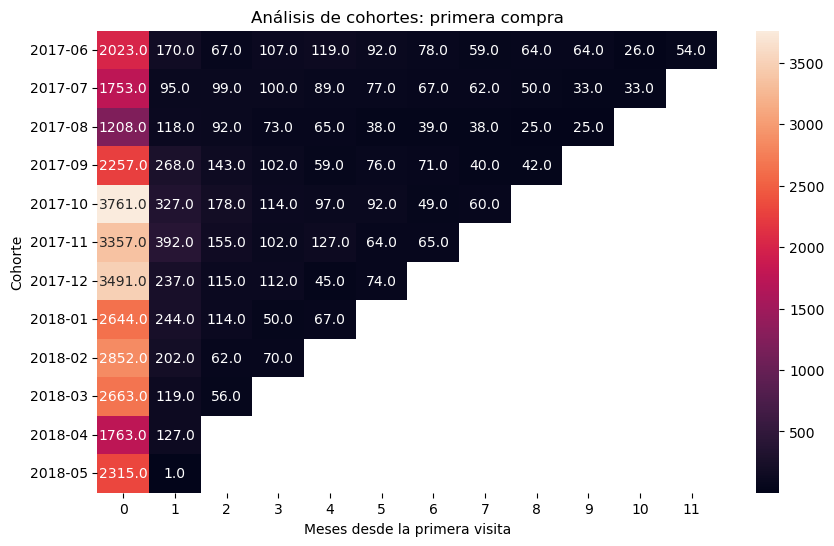

In [246]:
#Vamos a crear un mapa de calor para visualizar a las cohortes.
plt.figure(figsize=(10, 6))
sns.heatmap(cohort_matrix, annot=True, fmt='.1f', linecolor='black')
plt.title('Análisis de cohortes: primera compra')
plt.xlabel('Meses desde la primera visita')
plt.ylabel('Cohorte')
plt.show()


El mapa de calor nos muestra en que mes del ciclo de vida realizaron su primera compra los usuarios de las distintas cohortes mostradas. En general, la mayoría de personas realizan su primera compra en el primer mes de su ciclo de vida, y a partir del segundo mes, el número de usuarios que realizan su primera compra disminuye drasticamente. Podemos ver que para las cohortes de Octubre, Noviembre y Diciembre de 2017, el número de usuarios que realizaron su primera compra en el primer mes, fue de más de 3300 usuarios, lo cuál fue un pico para la empresa Showz, esto puede deberse a la estacionalidad, sin embargo, sin más datos, no podemos asegurarlo, pero respondiendo a la pregunta, las cohortes de ***Octubre, Noviembre y Diciembre*** de 2017 son las más efectivas hasta el momento. A continuación vamos a visualizar el tiempo promedio en días que tardan los usuarios en realizar su primera compra a partir del momento en el que se registran.

In [247]:
#Calculamos el tiempo que tarda cada usuario en realizar su primera compra.
cohort_df['time_to_conversion_days'] = (cohort_df['first_order'] - cohort_df['first_visit']).dt.days

#Calculamos el TTC (Time to conversion)
ttc = cohort_df['time_to_conversion_days'].mean()
print('EL tiempo promedio de conversión es de:', ttc.__round__(), 'días.')

EL tiempo promedio de conversión es de: 17 días.


El tiempo promedio que tardan los usuarios en realizar su primera compra a partir de su primera visita a la tienda, es de aproximadamente 17 días, notese que esta métrica fue calculada sin tener en cuenta las distintas cohortes, es algo más general. Sin embargo, como observamos en el mapa de calor mostrado anteriormente, la mayoría de usuarios realizan su primera compra en el primer mes de su ciclo de vida, y 16 días definitivamente están dentro del primer mes.

---

#### ¿Cuántos pedidos hacen durante un período de tiempo dado?
Para dar respuesta a esta pregunta, vamos a calcular el número de pedidos que se hacen mensualmente y posteriormente vamos a graficarlo para poder apreciarlo de manera más clara.

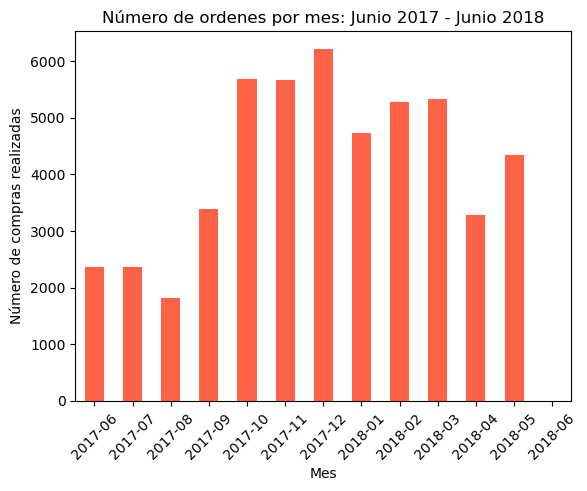

In [248]:
#Para poder obtener el número de pedidos por mes, necesitamos agrupar por mes, pero debido a que tenemos datos de dos años, vamos a modificar
#la columna de order_month primero.
orders_df['order_month'] = orders_df['order_date'].dt.strftime('%Y-%m')

#Ahora si podemos agrupar los datos.(también pudimos agrupar por order_year y order_month, pero prefiero hacerlo de esta manera, porque el groupby 
#será más sencillo)
orders_per_month = orders_df.groupby('order_month')['uid'].count()
orders_per_month.plot(
    kind='bar', 
    title='Número de ordenes por mes: Junio 2017 - Junio 2018',
    xlabel='Mes',
    ylabel='Número de compras realizadas',
    color='tomato',
    rot=45
)
plt.show()

Los meses en los que más compras se han realizado son los meses de Octubre, Noviembre y Diciembre de 2017, recordemos que estos también fueron los meses de las cohortes más efectivas, nuevamente, esto puede deberse a la estacionalidad, pero no tenemos una garantía. En dichos meses, se hicieron en los 3 casos más de 5,500 pedidos, para el mes de diciembre, fue el pico de ventas, superando las 6,000 ventas. A continuación vamos a calcular el promedio de ventas mensuales.

In [249]:
mean_orders_per_month = orders_per_month.mean()
print(f'Se realizan al rededor de {mean_orders_per_month.__round__()} compras mensuales')

Se realizan al rededor de 3878 compras mensuales


---

#### Tamaño promedio de compra.

In [250]:
#Vamos a calcular el tamaño promedio de las ordenes.
mean_revenue = orders_df['revenue'].mean().__ceil__()
print(f'EL tamaño promedio de cada compra es de {mean_revenue} dolares')
print('Orden mínima:', orders_df['revenue'].min())
print('Orden máxima:', orders_df['revenue'].max())

EL tamaño promedio de cada compra es de 5 dolares
Orden mínima: 0.0
Orden máxima: 2633.28


El tamaño promedio de la compra es de aproximadamente 5 dolares, pero me queda la duda, porque entre los valores mínimos y máximos existe una gran diferencia, si se tratara de una distribución normal, la media sería algo entre esos dos valores, sin embargo no lo es, vamos a investigar más sobre esto y a trazar un diagrama de caja para poder visualizar los valores atípicos.

<Axes: ylabel='revenue'>

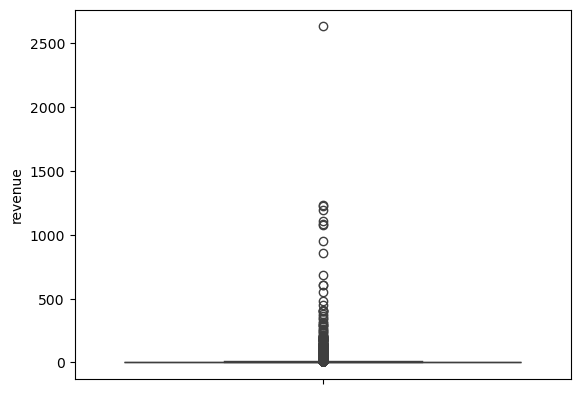

In [251]:
#Trazamos el diagrama de caja y bigotes.
sns.boxplot(orders_df['revenue'])

Bingo! como podemos ver, existe una gran cantidad de valores atípicos en las compras, estos valores representan compras de boletos de una gran cantidad de dinero, también es importante notar como la mayor parte de los datos esta ubicada casi en los valores mínimos, al ser estos la mayoría, la media esta más cerca de la mayor frecuencia de datos que de los valores atípicos.

----

#### LTV (Life Time Value)

In [252]:
cohort = visits_df.groupby('uid')['start_ts'].min().reset_index()
cohort.columns = ['uid', 'cohort_date']
cohort['cohort_month'] = cohort['cohort_date'].dt.to_period('M')
cohort.head()

,uid,cohort_date,cohort_month
0,11863502262781,2018-03-01 17:27:00,2018-03
1,49537067089222,2018-02-06 15:55:00,2018-02
2,297729379853735,2017-06-07 18:47:00,2017-06
3,313578113262317,2017-09-18 22:49:00,2017-09
4,325320750514679,2017-09-30 14:29:00,2017-09


In [253]:
#Vamos a unir los dataframes.
orders = pd.merge(orders_df, cohort, on='uid')
orders['order_month'] = orders['buy_ts'].dt.to_period('M')

#Ahora vamos a calcular el ciclo de vida.
orders['cohort_index'] = (orders['order_month'] - orders['cohort_month']).apply(attrgetter('n'))
orders.head()


,buy_ts,revenue,uid,order_date,order_year,order_month,order_dow,cohort_date,cohort_month,cohort_index
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017,2017-06,3,2017-06-01 00:09:00,2017-06,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017,2017-06,3,2017-06-01 00:14:00,2017-06,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017,2017-06,3,2017-06-01 00:25:00,2017-06,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017,2017-06,3,2017-06-01 00:14:00,2017-06,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017,2017-06,3,2017-06-01 07:31:00,2017-06,0


In [254]:
#Sumamos los ingresos por cohorte y ciclo de vida.
cohort_revenue = orders.groupby(['cohort_month', 'cohort_index'])['revenue'].sum().reset_index()
cohort_revenue.head()


,cohort_month,cohort_index,revenue
0,2017-06,0,9557.49
1,2017-06,1,2664.58
2,2017-06,2,1464.69
3,2017-06,3,3882.09
4,2017-06,4,3940.59


In [255]:
#Calculamos el número de usuarios por cohorte.
cohort_users = cohort.groupby('cohort_month')['uid'].nunique()


In [256]:
ltv = cohort_revenue.pivot(index='cohort_month', columns='cohort_index', values='revenue')
ltv = ltv.divide(cohort_users, axis=0)
ltv_cumulative = ltv.cumsum(axis=1)
ltv_cumulative

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-06,0.720830,0.921794,1.032262,1.325051,1.622252,1.835276,2.098489,2.269755,2.444573,2.707160,2.873387,3.018783
2017-07,0.751514,0.832129,0.916520,0.991326,1.055785,1.116522,1.161271,1.219893,1.275032,1.320011,1.355564,NaN
2017-08,0.612397,0.710356,0.808710,0.901649,0.981213,1.033556,1.081355,1.203763,1.285350,1.322254,NaN,NaN
2017-09,0.739775,0.961307,1.087662,1.712598,1.789734,1.904081,1.961962,1.991379,2.016437,NaN,NaN,NaN
2017-10,0.706868,0.853530,0.904614,0.945345,0.985514,1.024864,1.047149,1.072398,NaN,NaN,NaN,NaN
2017-11,0.606716,0.704616,0.753898,0.804160,0.844851,0.870821,0.896459,NaN,NaN,NaN,NaN,NaN
2017-12,0.667128,0.735952,0.902103,1.104882,1.162566,1.233095,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.468397,0.554664,0.606147,0.619667,0.642982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.518657,0.608059,0.637937,0.678528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


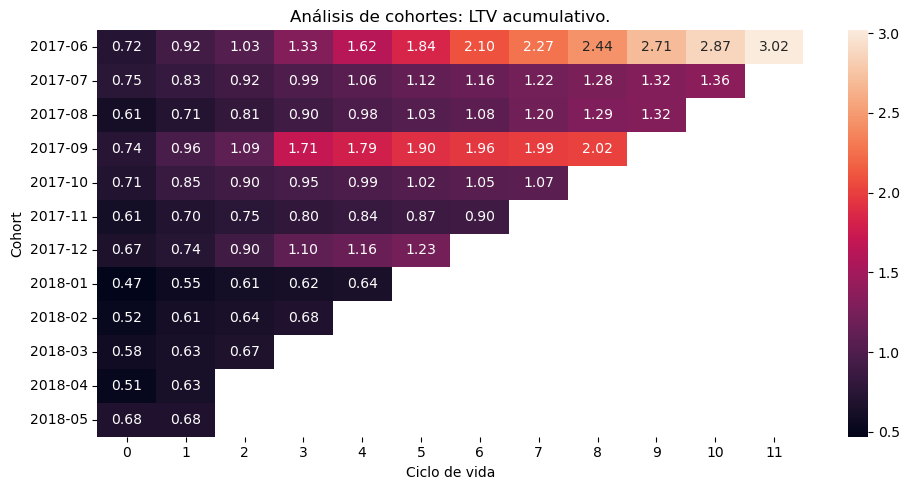

In [257]:
#Vamos a crear un heatmap para visualizar la matriz.
plt.figure(figsize=(10, 5))
sns.heatmap(ltv_cumulative, annot=True, fmt='.2f', linecolor='black')
plt.title('Análisis de cohortes: LTV acumulativo.')
plt.xlabel('Ciclo de vida')
plt.ylabel('Cohort')
plt.tight_layout()
plt.show()

El gráfico de arriba muestra el LTV promedio por usuario de cada cohorte, separado por el ciclo de vida de cada una de las cohortes. Podemos notar que la primera cohorte, es decir, la de Junio de 2017, es la más efectiva hasta ahora. Los usuarios de esta cohorte tienen el mayor promedio de LTV, incluso comparandolo con otras cohortes en el mismo ciclo de vida.

Otro punto a mencionar es que el LTV disminuyó gradualmente conforme avanzó el tiempo, cada cohorte fue disminuyendo su LTV, en comparación que la anterior. Pero ojo, a pesar de que el LTV es menor en comparación con el de la cohorte anterior, siempre va aumentando conforme avanza el ciclo de vida de la cohorte, aunque sea poco significativo, va aumentando.

---

### Marketing
Para continuar nuestro análisis, exploraremos un poco el area relacionada con los gastos de marketing, a continuación vamos a dar respuesta a las siguientes preguntas:

1. ¿Cuánto dinero se gastó?  (Total/por fuente de adquisición/a lo largo del tiempo) 
2. ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?
3. ¿Qué tan rentables eran las inversiones? (ROMI)

#### Total gastado por canal.

In [258]:
#Vamos a obtener el total invertido en cada canal, agrupamos por source id y sumamos el costo.
spent_per_source = costs_df.groupby('source_id')['costs'].sum()
spent_per_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

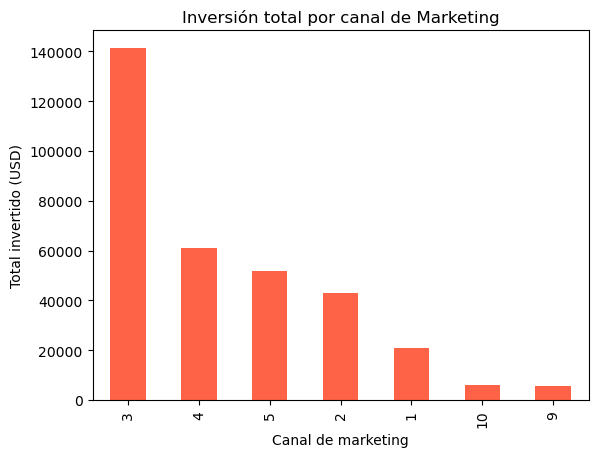

In [259]:
#A continuación vamos a graficar el total invertido por canal de marketing.
spent_per_source.sort_values(ascending=False).plot(kind='bar', 
                                                   title='Inversión total por canal de Marketing', 
                                                   xlabel='Canal de marketing', 
                                                   ylabel='Total invertido (USD)', 
                                                   color='tomato')
plt.show()

El canal de marketing en el cual se ha invertido más dinero ha sido el canal número 3, se han invertido más de 140,000 dolares, y hay una gran diferencia con respecto al segundo y tercer canal con mayor inversión, una diferencia de aproximadamente 80,000 dolares. Debido a las limitantes de la información, no podemos saber específicamente cual es el canal 3, es decir E-mail, por ejemplo. A continuación vamos a determinar cual de los canales ha traido más dinero a la empresa.

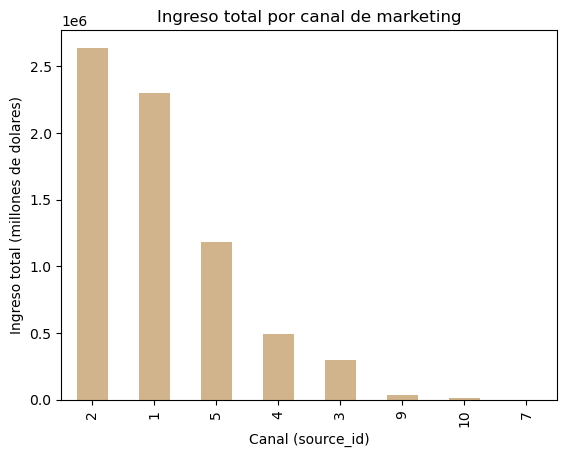

In [260]:
#primero tenemos que juntar la tabla de orders con la tabla de visitas para poder encontrar de que canal provinieron.
merged_df = pd.merge(orders_df, visits_df[['uid', 'source_id']], on='uid', how='left')

#Ahora vamos a agrupar por source_id y a sumar el ingreso total.
revenue_per_source = merged_df.groupby('source_id')['revenue'].sum().sort_values(ascending=False)

#Ahora vamos a visualizarlo.
revenue_per_source.plot(kind='bar', 
                      title='Ingreso total por canal de marketing', 
                      xlabel='Canal (source_id)', 
                      ylabel='Ingreso total (millones de dolares)', 
                      color='tan')
plt.show()

Esto de aquí arriba es uno de los hallazgos e insights más grandes del proyecto, los canales 2 y 1 son los que más dinero han traido a la empresa, ironicamente, también son 2 de los canales en los que menos se ha invertido. Mientras que el canal 3, en el cual mas se ha invertido, ha generado menos de 500,000 dolares para la empresa. Mas adelante, analizaremos la rentabilidad de estas inversiones.

---

#### CAC (Customer Adquisition Cost)

In [261]:
#Primero vamos a obtener el número de usuarios adquiridos por cada canal de marketing.
customers_by_source = merged_df.groupby('source_id')['uid'].nunique().reset_index()
customers_by_source.columns = ['source_id', 'n_clients']

In [262]:
#Ahora calculamos el total invertido por cada canal de marketing.
spent_per_source = costs_df.groupby('source_id')['costs'].sum().reset_index()
spent_per_source.columns = ['source_id', 'total_spent']

In [263]:
#Unimos ambos DataFrames para poder calcular el CAC
cac_df = pd.merge(customers_by_source, spent_per_source, on='source_id')

#Calculamos el CAC
cac_df['cac'] = cac_df['total_spent'] / cac_df['n_clients']
cac_df

,source_id,n_clients,total_spent,cac
0,1,7138,20833.27,2.918642
1,2,7305,42806.04,5.859828
2,3,13846,141321.63,10.206676
3,4,14253,61073.60,4.284965
4,5,10156,51757.10,5.096209
5,9,2793,5517.49,1.975471
6,10,1773,5822.49,3.283976


Arriba observamos el costo de adquisición de cada cliente, separado por canal de marketing. Como podemos ver, el mayor CAC es para los clientes provenientes de el canal número 3, nos cuesta aproximadamente 10 dolares adquirir a cada cliente por el canal 3. Mientras que los clientes más baratos vienen del canal número 9. Recordemos el principio de comparación para el CAC, "Si el LTV es mayor que el CAC, la economía es solida" por lo que debemos comparar esta nueva información con el LTV, anteriormente calculamos el LTV acumulativo, ahora vamos a calcular el LTV por canal para poder realizar la comparación.

#### LTV vs CAC (por canal de marketing)

In [264]:
#Realizamos el mismo procedimiento que con el CAC, para calcular el LTV por canal.
revenue_per_source = merged_df.groupby('source_id')['revenue'].sum().sort_values(ascending=False).reset_index()
revenue_per_source.columns = ['source_id', 'total_revenue']
ltv_by_source = revenue_per_source.merge(customers_by_source, on='source_id')
ltv_by_source['ltv'] = ltv_by_source['total_revenue'] / ltv_by_source['n_clients']
ltv_by_source

,source_id,total_revenue,n_clients,ltv
0,2,2638189.21,7305,361.148420
1,1,2298200.17,7138,321.966961
2,5,1181477.14,10156,116.332920
3,4,496690.17,14253,34.848114
4,3,296687.96,13846,21.427702
5,9,36342.25,2793,13.011905
6,10,14619.23,1773,8.245477
7,7,1.22,1,1.220000


Nota: Algo interesante es que solo se adquirió un cliente mediante el canal número 7, para ese canal, no hubo inversión, el cliente ha comprado poco más de un dolar en la tienda. Para la comparación con el CAC, voy a descartar a este canal, ya que no tiene sentido compararlo con algo que no tuvo inversión.

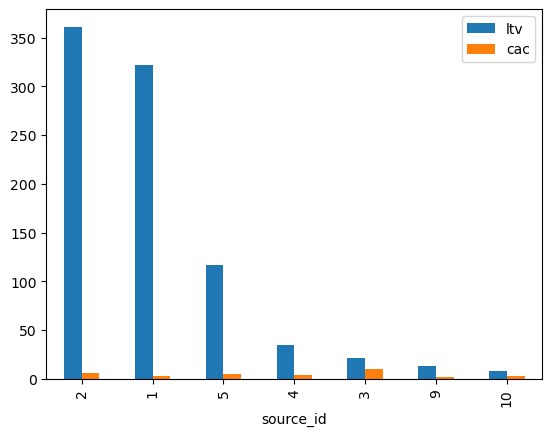

In [265]:
ltv_vs_cac = pd.merge(ltv_by_source, cac_df, on='source_id', how='inner')
ltv_vs_cac.plot(kind='bar', 
                x='source_id', 
                y=['ltv', 'cac'])
plt.show()

En todos los casos el LTV es mayor que el CAC, lo cual a primera vista es un buen indicativo, los usuarios provenientes de los canales 2 y 1 gastan mucho más de lo que costaron.


---

#### ROMI (Return On Marketing Investment) por canal de marketing
A continuación vamos a evaluar la rentabilidad de la empresa mediante el ROMI, haremos el cálculo agrupando los datos por canal/fuente en la cual se invirtió.

In [266]:
ltv_vs_cac['romi'] = ltv_vs_cac['ltv'] / ltv_vs_cac['cac']
ltv_vs_cac[['source_id', 'romi']].sort_values(by='romi', ascending=False)

,source_id,romi
1,1,110.313944
0,2,61.631237
2,5,22.827344
3,4,8.132649
5,9,6.586736
6,10,2.510821
4,3,2.099381


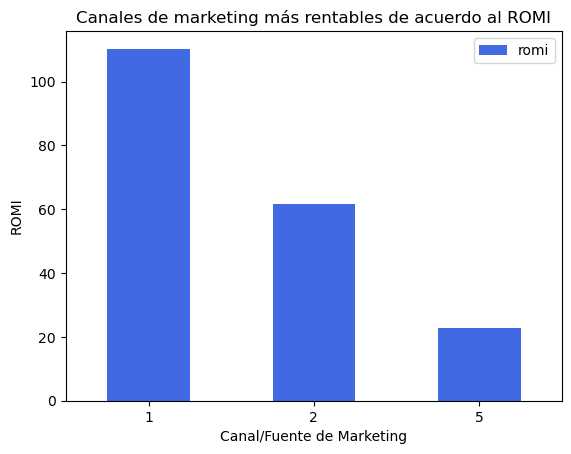

In [267]:
filtered_df = ltv_vs_cac.query('romi > 20').sort_values(by='romi', ascending=False).reset_index(drop=True)
filtered_df.plot(kind='bar', 
                 x='source_id', 
                 y='romi', 
                 title='Canales de marketing más rentables de acuerdo al ROMI', 
                 xlabel='Canal/Fuente de Marketing', 
                 ylabel='ROMI', 
                 color='royalblue',
                 rot=0)
plt.show()

Arriba tenemos una de las métricas más importantes para medir el desempeño y rentabilidad de las inversiones en Marketing; el ROMI, el ROMI nos dice cuantos dolares ganamos por cada dolar invertido, permitanme explicarme, por cada dolar que invertimos en el canal número 1, ganamos 110 en valor promedio del cliente. Dado que en nuestra tabla todos los valores de ROMI son mayores a 1, todas son inversiones rentables, sin embargo el margen de ganancia que existe para cada uno es distinto y esto puede significar que uno es mejor que otro. Dicho esto, los canales de marketing más efectivos y rentables para la empresa son el 1, 2 y hasta el 5, el canal 1 es sobre todos el mejor, con un ROMI de 110 supera amplicamente al canal 2 que es el segundo más rentable con un ROMI de 61, este a su vez supera ampliamente al tercer canal más rentable que es el 5 con un ROMI de 22. Como ya mencioné antes, todos los canales son rentables, sin embargo estos 3 superan ampliamente a los demás.

#### Análisis de cohortes ROMI

---

#### Variaciones de las métricas por dispositivo y tiempo.
A continuación vamos a calcular el LTV por dispositivo y por mes para ver como varía esta metrica con respecto a los distintos dispositivos y con el paso del tiempo.

In [ ]:
#Para calcular esas métricas necesitamos primero modificar nuestro DataFrame de orders, hay que agregarle el dispositivo del cual provino el 
#cliente.
merged_df = pd.merge(orders_df, visits_df[['uid', 'source_id', 'device']], on='uid', how='left')
#Ahora podemos trabajar con este DF, a continuación vamos a calcular el LTV por dispositivo

##### Análisis por dispositivo

In [277]:
#Vamos a calcular el LTV por dispositivo.
ltv_by_device = merged_df.groupby('device').agg({
    'revenue': 'sum',
    'uid': pd.Series.nunique
})
ltv_by_device['ltv'] = ltv_by_device['revenue'] / ltv_by_device['uid']
ltv_by_device = ltv_by_device.reset_index()
ltv_by_device.columns = ['device', 'revenue', 'users_count', 'ltv']
ltv_by_device

,device,revenue,users_count,ltv
0,desktop,6447893.99,30602,210.701719
1,touch,514313.36,8912,57.710206


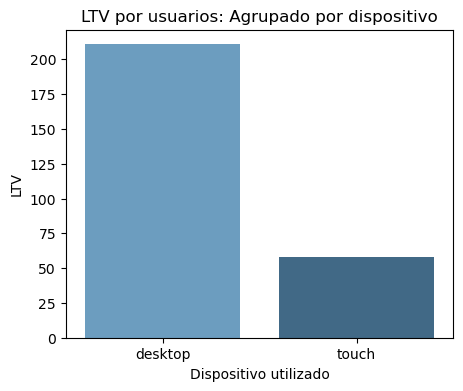

In [289]:
#Vamos a visualizar el ltv de los usuarios, por dispositivo.
plt.figure(figsize=(5, 4))
sns.barplot(data=ltv_by_device, x='device', y='ltv', palette='Blues_d', hue='device')
plt.title('LTV por usuarios: Agrupado por dispositivo')
plt.xlabel('Dispositivo utilizado')
plt.ylabel('LTV')
plt.show()

Como podemos ver, el LTV para los usuarios provenientes de "Desktop"(PC, laptop) es mucho mayor que el LTV de los usuarios provenientes de "Touch"(Celular, Tablet, etc.) El LTV de los usuarios de Desktop es de un poco más de 200 dolares, mientras que el LTV de los usuarios de Touch es de poco más de 50 dolares. Esto es una diferencia de aproximadamente 150 dolares. Es algo muy interesante ya que atraves de esto, el departamento de marketing podría incentivar y promocionar en mayor medida en PC o laptop. 

---

##### Métricas por tiempo(Mes).

In [290]:
#Primero convertimos la columna order_month a tipo datetime de mes.
merged_df['order_month'] = pd.to_datetime(merged_df['order_date']).dt.to_period('M')
merged_df.dtypes

buy_ts         datetime64[ns]
revenue               float64
uid                    uint64
order_date     datetime64[ns]
order_year              int32
order_month         period[M]
order_dow               int32
source_id               int64
device                 object
dtype: object

In [293]:
#Ahora vamos a calcular el LTV mensual.

#Agrupamos por mes para calcular el LTV.
ltv_by_month = merged_df.groupby('order_month').agg({
    'revenue': 'sum',
    'uid': pd.Series.nunique
})
#Calculamos el LTV
ltv_by_month['ltv'] = ltv_by_month['revenue'] / ltv_by_month['uid']

#Damos formato al DataFrame.
ltv_by_month = ltv_by_month.reset_index()
ltv_by_month.columns = ['order_month', 'revenue', 'users_count', 'ltv']

ltv_by_month

,order_month,revenue,users_count,ltv
0,2017-06,148121.29,2023,73.218631
1,2017-07,253987.24,1984,128.017762
2,2017-08,211562.04,1472,143.724212
3,2017-09,738489.76,2750,268.541731
4,2017-10,687489.99,4675,147.056682
5,2017-11,497997.76,4547,109.522270
6,2017-12,1445074.82,4942,292.406884
7,2018-01,504331.57,3898,129.382137
8,2018-02,667585.76,4258,156.783880
9,2018-03,815240.79,4181,194.987034


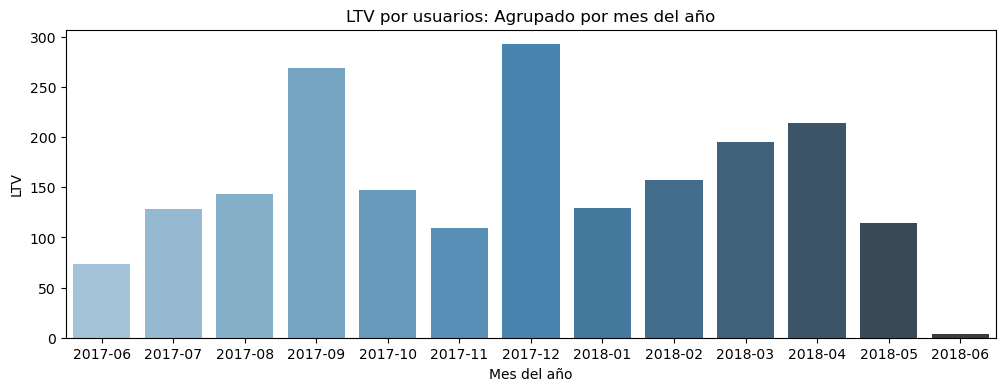

In [307]:
#Vamos a visualizar el ltv de los usuarios, por mes.
plt.figure(figsize=(12, 4))
sns.barplot(data=ltv_by_month, x='order_month', y='ltv', palette='Blues_d', hue='order_month')
plt.title('LTV por usuarios: Agrupado por mes del año')
plt.xlabel('Mes del año')
plt.ylabel('LTV')
plt.show()

Lo que estamos viendo representa el LTV mensual promedio de los usuarios que hicieron compras ese mes, algo interesante es que el mayor LTV lo tuvieron los usuarios que hicieron compras en Diciembre de 2017, con casi $300 dolares. En septiembre de 2017 el LTV también fue considerablemente alto con más de $250 dolares. Quiero aclarar que esto no es un análisis de cohortes, no estamos separando a los usuarios por mes de registro. Esta gráfica nos permite identificar que tan rentables son los usuarios mes a mes, en general constantes con ciertos picos y bajones, (en el último mes solo hubo un usuario, probablemente porque los datos que tenemos están limitados en fechas) también nos permite ver que hubo meses en los cuales hubo un mejor desempeño y si tuvieramos datos de una mayor cantidad de tiempo, podríamos identificar patrones de estacionalidad por ejemplo.

---

## Paso 3: Conclusiones e insights.